# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**: Sara Buchta

**ID**: srb289

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [10]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\srbuc\OneDrive\Desktop\lab\lab2-srb289`


In [11]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [12]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [13]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 ⋮
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

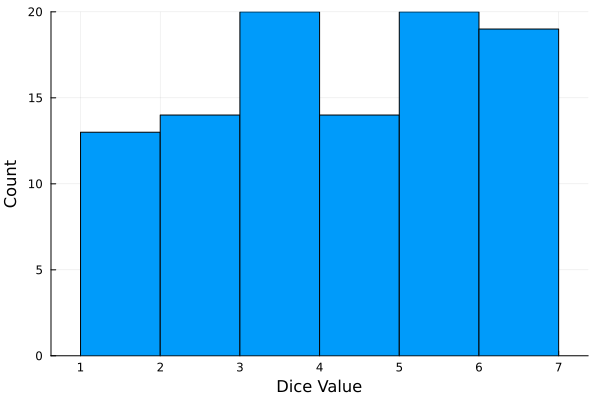

In [14]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

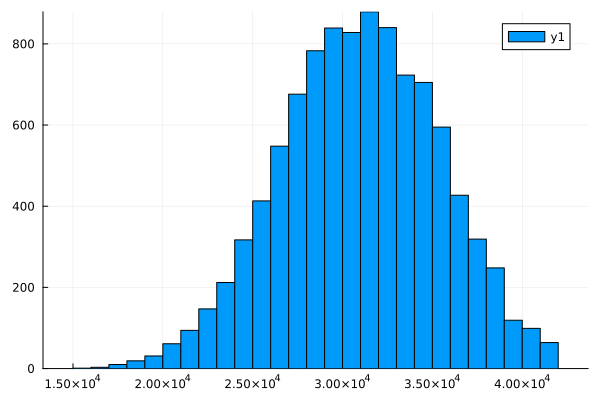

In [68]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Approach:

We will need to plot, so will initialize a list est to hold the running estimate at each iteration. I will chose an initial number of iterations, and will increase it if the running estimate does not need to stabilize.

For each iteration, the code should generate the showcase value (rounding to an even dollar amount), and check if the bid is higher or lower. If the bid is lower, the code should generate a competitor bid, and determine if the bid is outbid or not. First, it will check if the guess is within 250 of the showcase value, and is either greater than the competitor bid or the competitor overbid. In this case, the winnings is double the showcase value. If not, it checks if the competitor had a higher bid that is not over the showcase value. In this case, the winnings are zero. If none of the above are true, then the guess was good and the winnings are the showcase value.

At the end or each "round" of simulation, the code will average all the winnings so far to get the new estimated average winnings.

To check the competitor bid, we can assume that the competitor bid is uniformly distributed between 0 and the showcase value, as this will give the linear behavior described above.

In [130]:
iters = 1000
est = zeros(iters)
winnings = zeros(iters)
guess = 35000
for x in 1:iters
    showcase_val = round(rand(showcase_dist))

    if guess > showcase_val
        winnings[x] = 0

    else
        competitor_guess = rand(Uniform(0,showcase_val))

        if guess >= showcase_val - 250 && (guess > competitor_guess || competitor_guess > showcase_val)
            winnings[x] = 2*showcase_val

    
        elseif competitor_guess > guess && competitor_guess <= showcase_val
            winnings[x] = 0

        else
            winnings[x] = showcase_val

        end
    end

    est[x] = sum(winnings[1:x])/x
    
end

In [131]:
display("Estimated winnings: ")
display(est[iters])


"Estimated winnings: "

6535.166

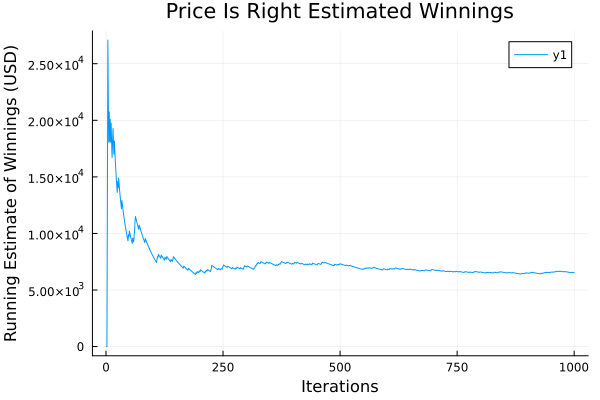

In [132]:
plot(est)
xlabel!("Iterations")
ylabel!("Running Estimate of Winnings (USD)")
title!("Price Is Right Estimated Winnings")



Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

When I increased the number of iterations to 1000, the estimted winnings seems to have mostly stabilized, so I used this as the number of iterations. The expected winnings if $35,00 is bid is $6,500

Now, to acheive our goal of finding the optimal wager, we can rewrite the code above as a function of the guess, and plot the estimated winnings for a variety of wagers. Then, we could identify a reasonable range for a bisection search. For this, I am upping the number of iterations to 5000 to get more precise simulation outputs.

In [149]:
function est_winnings(guess)
    iters = 5000
    est = zeros(iters)
    winnings = zeros(iters)
    for x in 1:iters
        showcase_val = round(rand(showcase_dist))

        if guess > showcase_val
            winnings[x] = 0

        else
            competitor_guess = rand(Uniform(0,showcase_val))

            if guess >= showcase_val - 250 && (guess > competitor_guess || competitor_guess > showcase_val)
                winnings[x] = 2*showcase_val

        
            elseif competitor_guess > guess && competitor_guess <= showcase_val
                winnings[x] = 0

            else
                winnings[x] = showcase_val

            end
        end

        est[x] = sum(winnings[1:x])/x
    end
    return(est[iters])
end



est_winnings (generic function with 1 method)

In [150]:
estimated_winnings = zeros(11)
i = 1
for x in 20000:2000:40000
    estimated_winnings[i] = est_winnings(x)
    i = i + 1
end
display(estimated_winnings)

11-element Vector{Float64}:
 19969.7502
 21581.4878
 22651.3492
 22892.3076
 21618.7404
 18194.017
 14036.8142
  9021.8454
  4941.6972
  1986.4624
   871.538

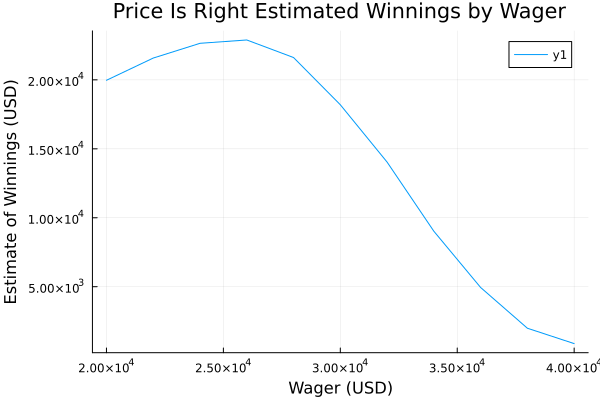

In [153]:
plot(20000:2000:40000,estimated_winnings)
xlabel!("Wager (USD)")
ylabel!("Estimate of Winnings (USD)")
title!("Price Is Right Estimated Winnings by Wager")


It appears the optimal wager is around $26,000. To get a more precise answer, I would use a bisection sort between $24,000 and $28,000, and might increase the number of iterations to make the results even more precise. I would set the stopping error for the bisection sort to be around the random error in outputs of the Monte Carlo simulation. Unfortunately, I ran out of time.

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

Discussed with Gianna Weidman